In [1]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import numpy as np

## Load the data

In [2]:
tesla = pd.read_csv('tesla_stock.csv')
tesla.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-06-29,3.800,5.000,3.508,4.778,4.778,93831500
1,2010-06-30,5.158,6.084,4.660,4.766,4.766,85935500
2,2010-07-01,5.000,5.184,4.054,4.392,4.392,41094000
3,2010-07-02,4.600,4.620,3.742,3.840,3.840,25699000
4,2010-07-06,4.000,4.000,3.166,3.222,3.222,34334500


# Shape of the data

In [3]:
tesla.shape

(2782, 7)

In [4]:
def get_data(df):
    start_date = datetime.datetime.strptime(df['Date'].min(), '%Y-%m-%d')
    end_date = datetime.datetime.strptime(df['Date'].max(), '%Y-%m-%d')
    data_duration = (end_date - start_date).days

    print(f"Start Date: {df['Date'].min()}")
    print(f"End Date: {df['Date'].max()}")
    print(f"Date Differences: {data_duration}")
    print(f"Total rows: {df.shape[0]}")
    print(f"Total columns: {df.shape[1]}")

In [5]:
get_data(tesla)

Start Date: 2010-06-29
End Date: 2021-07-16
Date Differences: 4035
Total rows: 2782
Total columns: 7


##  Information summery about the features

In [6]:
tesla.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2782 entries, 0 to 2781
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2782 non-null   object 
 1   Open       2782 non-null   float64
 2   High       2782 non-null   float64
 3   Low        2782 non-null   float64
 4   Close      2782 non-null   float64
 5   Adj Close  2782 non-null   float64
 6   Volume     2782 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 152.3+ KB


## Statistics of the Data

In [7]:
tesla.describe()

,Open,High,Low,Close,Adj Close,Volume
count,2782.000000,2782.000000,2782.000000,2782.000000,2782.000000,2.782000e+03
mean,91.749857,93.728493,89.589945,91.772104,91.772104,3.174992e+07
std,165.673025,169.332508,161.468110,165.658972,165.658972,2.869178e+07
min,3.228000,3.326000,2.996000,3.160000,3.160000,5.925000e+05
25%,8.395500,8.465000,8.132000,8.367500,8.367500,1.215288e+07
50%,45.476000,46.169000,44.587000,45.399999,45.399999,2.528800e+07
75%,63.346500,64.606503,62.257998,63.456000,63.456000,4.081700e+07
max,891.380005,900.400024,871.599976,883.090027,883.090027,3.046940e+08


In [8]:
tesla.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

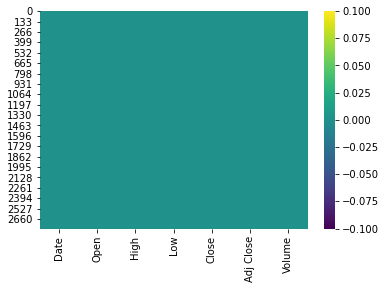

In [9]:
sns.heatmap(tesla.isnull(),cmap='viridis');

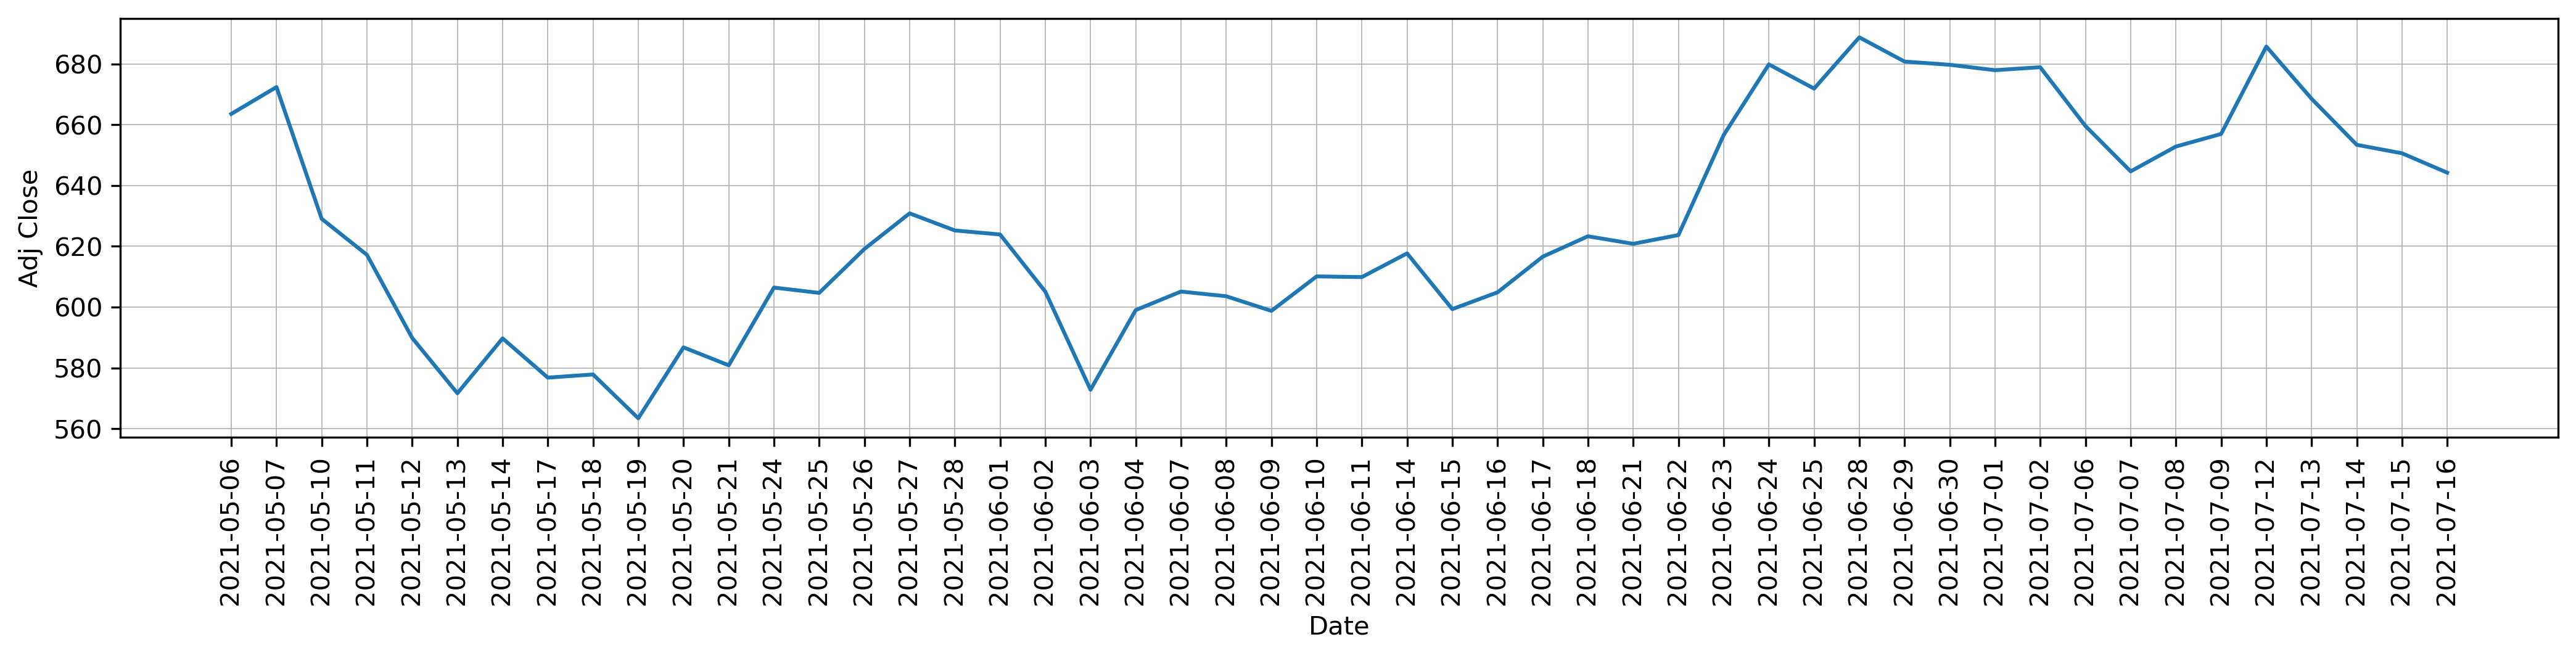

In [10]:
plt.rcParams.update({'figure.figsize': (17, 3), 'figure.dpi':300})
fig, ax = plt.subplots()
sns.lineplot(data=tesla.tail(50), x='Date', y='Adj Close')
plt.grid(linestyle='-', linewidth=0.4)
ax.tick_params(axis='x', rotation=90)


In [11]:
tesla.columns = ['date', 'open', 'high', 'low', 'close', 'adjusted_close', 'volume']
tesla['prev_adjusted_close'] = tesla['adjusted_close'].shift(1)
tesla['prev_volume'] = tesla['volume'].shift(1)
tesla['day_of_week'] = pd.to_datetime(tesla['date']).dt.dayofweek
data = tesla[['date', 'adjusted_close', 'prev_adjusted_close', 'prev_volume', 'day_of_week']].dropna()
data.sample()

,date,adjusted_close,prev_adjusted_close,prev_volume,day_of_week
2516,2020-06-26,191.947998,197.195999,46272500.0,4


In [12]:
categorical_features = ['day_of_week']
numerical_features = ['prev_adjusted_close', 'prev_volume']
label = 'adjusted_close'

In [13]:
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder
from sklearn_pandas import DataFrameMapper
from pytrends.request import TrendReq


In [14]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder

#Spliting the data
train_df, test_df = train_test_split(data, test_size=0.1, shuffle=False)
X_train, y_train = train_df[categorical_features + numerical_features], train_df[label]
X_test, y_test = test_df[categorical_features + numerical_features], test_df[label]

#Normalizing the features
from sklearn_pandas import DataFrameMapper
num = [([n], [StandardScaler()]) for n in numerical_features]
cat = [([n], [OrdinalEncoder()]) for n in categorical_features]
mapper = DataFrameMapper(num + cat, df_out=True)

#Fit the data
preprocessed_X_train = mapper.fit_transform(X_train)
preprocessed_X_train = sm.add_constant(preprocessed_X_train)
results = sm.OLS(y_train, preprocessed_X_train).fit()
results.summary()

C:\Users\RIMISHA\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         adjusted_close   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.995
Method:                 Least Squares   F-statistic:                 1.733e+05
Date:                Tue, 28 Sep 2021   Prob (F-statistic):               0.00
Time:                        17:23:58   Log-Likelihood:                -5438.8
No. Observations:                2502   AIC:                         1.089e+04
Df Residuals:                    2498   BIC:                         1.091e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  41.1359      0.075    549.627      0.000      40.989      41.283
prev_adjusted_close    30.6598      0.052    586.320      0.000      30.557      30.762
prev_volume             0.0467      0.052      0.892      0.372      -0.056       0.149
day_of_week            -0.0918      0.030     -3.019      0.003      -0.151      -0.032
==============================================================================
Omnibus:                     1014.937   Durbin-Watson:                   1.927
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           262833.236
Skew:                          -0.683   Prob(JB):                         0.00
Kurtosis:                      53.193   Cond. No.                         4.84
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Training the Model

In [17]:
def SuperModel(pipeline, X, y):
    y_prediction = pipeline.predict(X)
    return{        
        'MAE': mean_absolute_error(y, y_prediction),
        'y_pred': y_prediction
    }

In [21]:
mapper = DataFrameMapper(num + cat, df_out=True)
clf = LinearRegression()
pipeline = Pipeline([
    ('preprocess', mapper),
    ('clf', clf)
])

pipeline.fit(X_train, y_train)
results = SuperModel(pipeline, X_test, y_test)
print(f"Our Model's MAE: {round(results['MAE'], 2)}")

Our Model's MAE: 16.72


In [51]:
tesla_Time = pd.DataFrame(data={
    'date': test_df['date'].reset_index().drop('index', axis=1)['date'],
    'predictions': results['y_pred'],
    'True value': y_test.reset_index().drop('index', axis=1)['adjusted_close']})
tesla_Time.sample()

,date,predictions,True value
54,2020-08-25,403.541285,404.667999


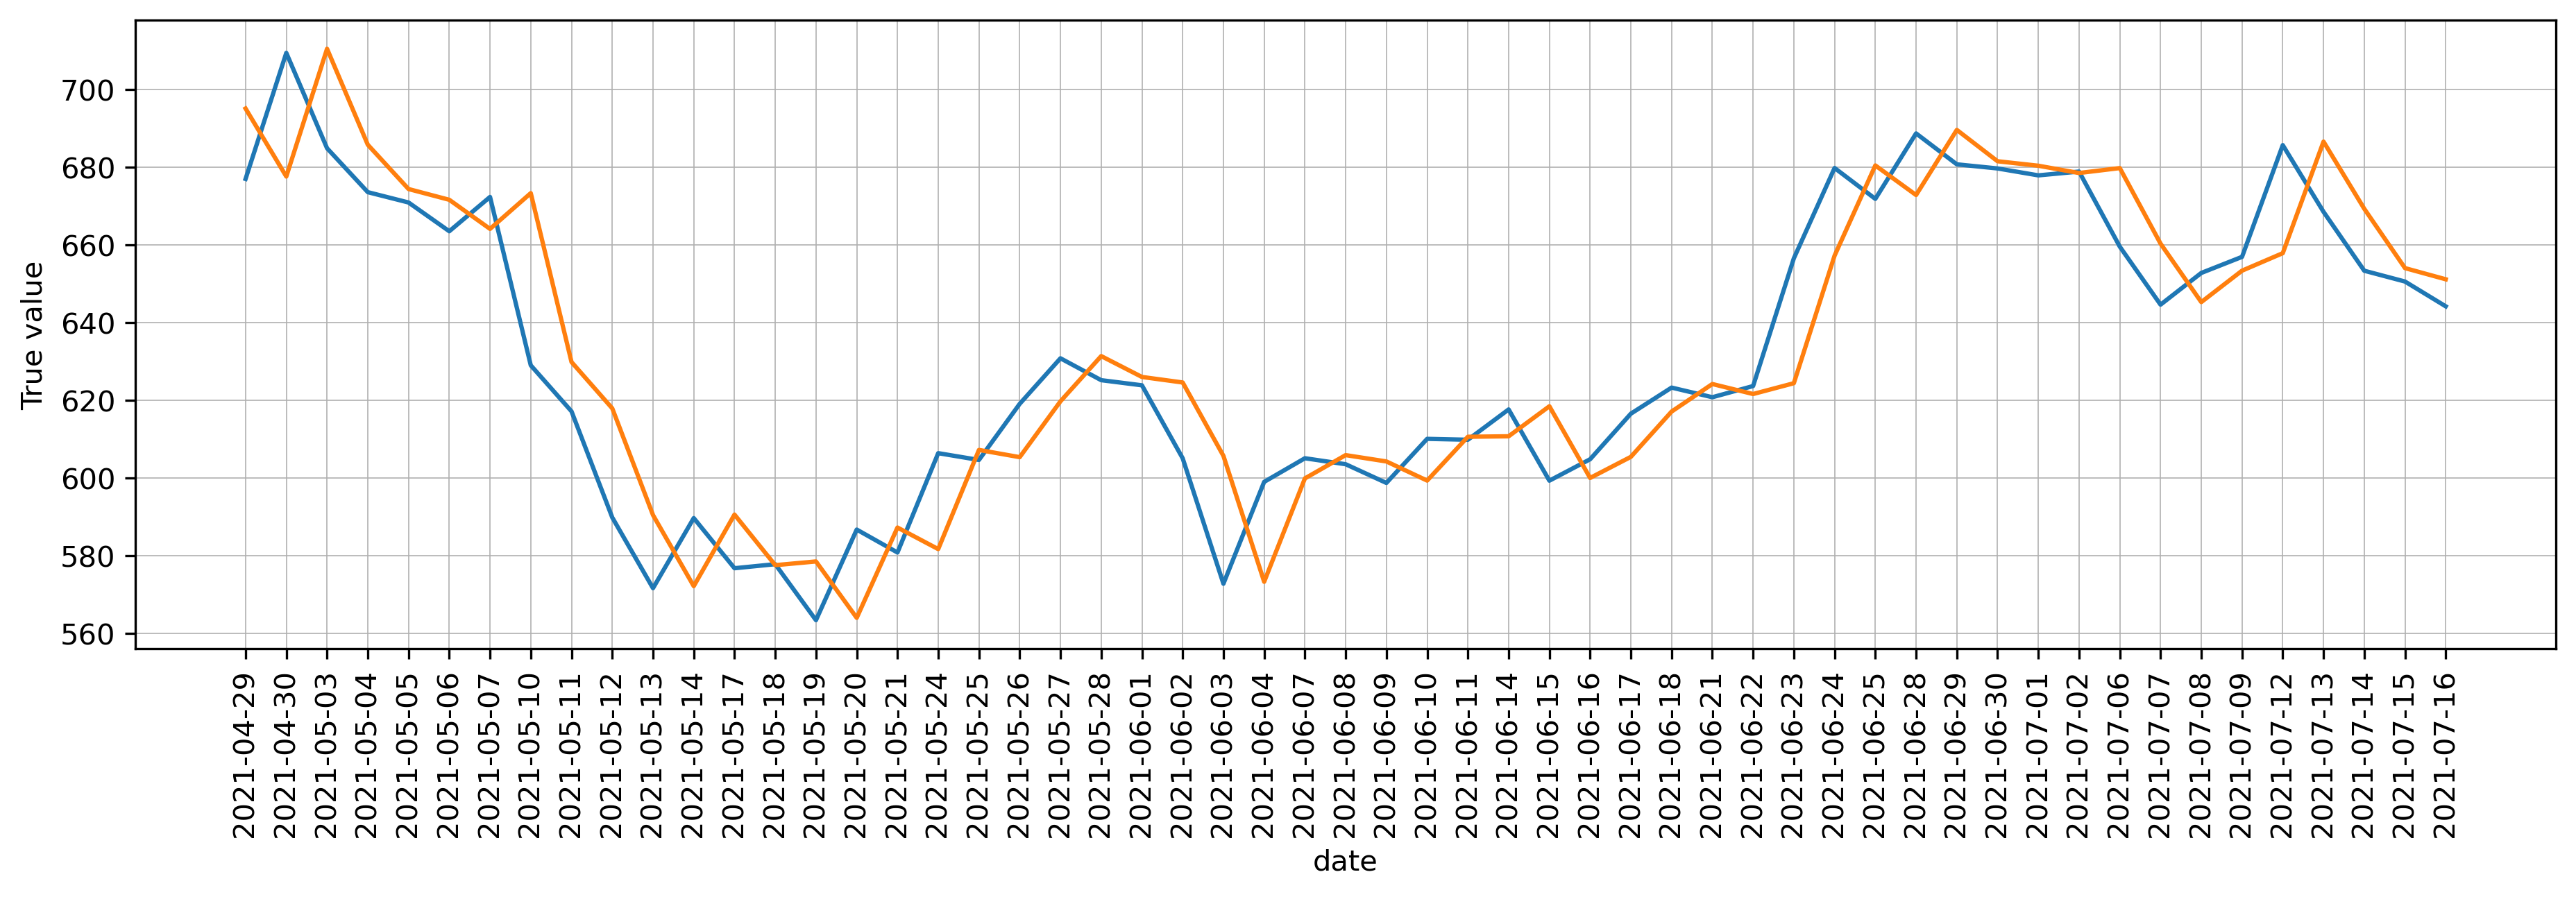

In [52]:
plt.rcParams.update({'figure.figsize': (15, 4), 'figure.dpi':300})
fig, ax = plt.subplots()
sns.lineplot(data=tesla_Time.tail(55), x='date', y='True value')
sns.lineplot(data=tesla_Time.tail(55), x='date', y='predictions')
plt.grid(linestyle='-', linewidth=0.4)
ax.tick_params(axis='x', rotation=90)

In [53]:
tesla_Time.tail()

,date,predictions,True value
274,2021-07-12,657.899066,685.700012
275,2021-07-13,686.603344,668.539978
276,2021-07-14,669.323372,653.380005
277,2021-07-15,654.055508,650.599976
278,2021-07-16,651.178141,644.219971
